# Potential due to a planet with square shape

We want to evaluate the potential due to an
arbitrary distribution of mass density.


$$G(\mathbf{r}, \boldsymbol{\zeta})
   = \frac{1}{2\pi}\ln|\mathbf{r} - \boldsymbol{\zeta}|\, .$$
   
   
The flow is given by

$$F(\mathbf{r}, \boldsymbol{\xi})
   = -\frac{\hat{\mathbf{r}}}{2\pi |\mathbf{r} - \boldsymbol{\xi}|} \, ,$$
   
with $\hat{\mathbf{r}}$ a unit vector from $\mathbf{r}$ to
$\boldsymbol{\xi}$.


We can compute the potential/field given by a distribution of
mass density $\rho(\mathbf{x})$ adding up the individual
point contributions, that is, with an integral.

$$\phi(\boldsymbol{\xi})
= \int\limits_\Omega G(\mathbf{x}, \boldsymbol{\xi})
  \rho(\mathbf{x})\, \mathrm{d}\Omega(\mathbf{x})$$
  
If we consider that the domain is triangulated we can express the integral as

$$\phi(\boldsymbol{\xi})
= \sum_{e}\int\limits_{\Omega_e} G(\mathbf{x}, \boldsymbol{\xi})
  \rho(\mathbf{x})\, \mathrm{d}\Omega(\mathbf{x})\, .$$
  
Let's consider that the variation of $\rho$ and $G$ is negligible over
each triagle. Thus, we obtain

\begin{align}
\phi(\boldsymbol{\xi})
&\approx \sum_{e} G(\mathbf{x}_m, \boldsymbol{\xi}) \rho(\mathbf{x}_m) \int\limits_{\Omega_e}\mathrm{d}\Omega(\mathbf{x})\\
&= \sum_{e} G(\mathbf{x}_m, \boldsymbol{\xi}) \rho(\mathbf{x}_m) V_e\, ,
\end{align}

where $\mathbf{x}_m$ refers to the centroid of each triangle.

If we consider that the density is the same over the domain, we get

$$\phi(\boldsymbol{\xi})
\approx \rho \sum_{e} G(\mathbf{x}_m, \boldsymbol{\xi}) V_e\, .$$

In [1]:
#%matplotlib widget

In [2]:
import numpy as np
from numpy import log, arctan2, pi, mean
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
import meshio

try:
    repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
    style = repo + "/styles/clean.mplstyle"
    plt.style.use(style)
except:
    pass

In [3]:
mesh = meshio.read("files/square_planet.msh")
pts = mesh.points
tris_planet = mesh.cells[0].data
tris = np.vstack([cells.data for cells in mesh.cells])
x, y, _ = pts.T

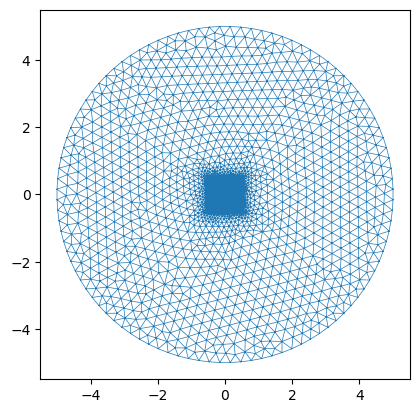

In [4]:
plt.figure()
plt.triplot(x, y, tris, lw=0.5, zorder=4)
plt.axis("image");

In [5]:
def green_pot_2d(r):
    """Green function for Laplace equation
    
    Parameters
    ----------
    r : float
        Distance between the two points.

    Returns
    -------
    phi : float
        Value of the potential.
    """
    return 0.5*np.log(r)/np.pi

In [6]:
def green_field_2d(r, unit_vec):
    """Derivative of the Green function for Laplace equation
    
    Parameters
    ----------
    r : float
        Distance between the two points.
    unit_vec : ndarray, float
        Unit vector from the source point to evaluation
        point.

    Returns
    -------
    E : float
        Flow field.
    """
    nx, ny = unit_vec
    Ex = -0.5*nx/(r * np.pi)
    Ey = -0.5*ny/(r * np.pi)
    return Ex, Ey

In [7]:
def area_tri(coords):
    """Compute the area of a triangle with given coordinates

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes of the triangle.

    Returns
    -------
    area : float
        Area of the triangle
    """
    mat = coords.copy()
    mat[:, 2] = 1
    return 0.5 * np.abs(np.linalg.det(mat))

In [8]:
potential = np.zeros_like(x)
field = np.zeros_like(pts[:, :2])

# Crear una lista para almacenar las coordenadas de los puntos fuente
source_points = []

In [19]:
# Crear listas para almacenar las coordenadas de los puntos fuente y de observación
source_points = []
observation_points = []

for tri in tris_planet:
    coords = pts[tri]
    area = area_tri(coords)
    xm, ym, _ = np.mean(coords, axis=0)
    for cont, pt in enumerate(pts):
        pt_x, pt_y, _ = pt
        vec = np.array([pt_x - xm, pt_y - ym])
        r = np.linalg.norm(vec)
        unit_vec = vec/r
        pot = green_pot_2d(r)
        Ex, Ey = green_field_2d(r, unit_vec)
        potential[cont] += area * pot
        field[cont, :] += area * Ex, area * Ey
        
        # Agregar el punto fuente a la lista
        source_points.append((pt_x, pt_y))
        
        # Agregar el punto de observación a la lista
        observation_points.append((xm, ym))



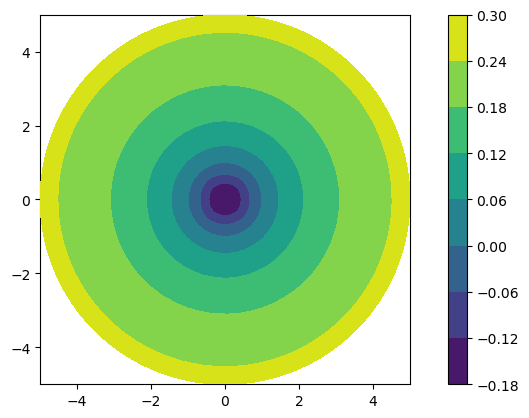

In [11]:
plt.figure()
plt.tricontourf(x, y, tris, potential, zorder=4)
plt.colorbar()
plt.axis("image");

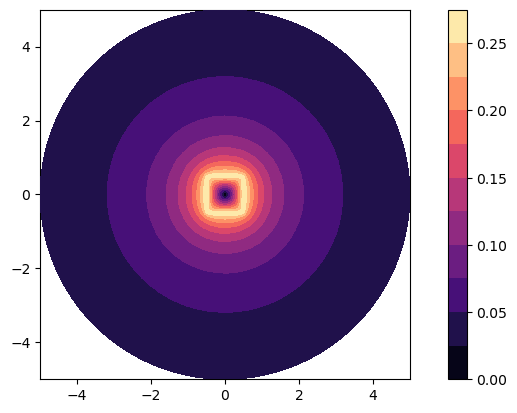

In [12]:
plt.figure()
plt.tricontourf(x, y, tris, np.linalg.norm(field, axis=1),
                12, cmap="magma", zorder=4)
plt.colorbar()
plt.axis("image");

In [13]:
mesh.point_data["potential"] = potential

In [14]:
mesh.point_data["field"] = field

In [16]:
import os

folder = "./files/"
if os.path.isdir(folder):
    pass
else:
    os.mkdir(folder)
    
mesh.write( folder + "square_planet.vtk")